In [1]:
import pandas as pd
import numpy as np

path = "../data/house_prices/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

In [2]:
from utils.models import CatBoostCV, LGBMCV
from utils.eda import reduce_mem_usage, missing_data, get_cats_nums

In [3]:
train.columns = [f.lower() for f in train.columns]
test.columns = [f.lower() for f in test.columns]

In [4]:
train.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paveddrive

In [6]:
missing_data(train)

,Total,Percent
poolqc,1453,99.520548
miscfeature,1406,96.301370
alley,1369,93.767123
fence,1179,80.753425
fireplacequ,690,47.260274
...,...,...
centralair,0,0.000000
salecondition,0,0.000000
heating,0,0.000000
totalbsmtsf,0,0.000000


In [7]:
missing_data(test)

,Total,Percent
poolqc,1456,99.794380
miscfeature,1408,96.504455
alley,1352,92.666210
fence,1169,80.123372
fireplacequ,730,50.034270
...,...,...
electrical,0,0.000000
centralair,0,0.000000
heatingqc,0,0.000000
foundation,0,0.000000


# Drop columns that 90% is missing

In [8]:
miss = missing_data(train)

In [9]:
drop_cols = miss.loc[miss['Percent'] > 90.].index.tolist()

In [10]:
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

In [11]:
train.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,3ssnporch,screenporch,poolarea,fence,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,NaN,0,12,2008,WD,Normal,250000


# Let's just impute right away for the sake of demo.

In [12]:
unused_cols = ['id', 'saleprice']

In [13]:
cats, nums = get_cats_nums(train)

In [14]:
cats

['mszoning',
 'street',
 'lotshape',
 'landcontour',
 'utilities',
 'lotconfig',
 'landslope',
 'neighborhood',
 'condition1',
 'condition2',
 'bldgtype',
 'housestyle',
 'roofstyle',
 'roofmatl',
 'exterior1st',
 'exterior2nd',
 'masvnrtype',
 'exterqual',
 'extercond',
 'foundation',
 'bsmtqual',
 'bsmtcond',
 'bsmtexposure',
 'bsmtfintype1',
 'bsmtfintype2',
 'heating',
 'heatingqc',
 'centralair',
 'electrical',
 'kitchenqual',
 'functional',
 'fireplacequ',
 'garagetype',
 'garagefinish',
 'garagequal',
 'garagecond',
 'paveddrive',
 'fence',
 'saletype',
 'salecondition']

In [15]:
nums = [f for f in nums if f not in unused_cols]

In [16]:
import gc; gc.enable()
for cat in cats:
    impute_value = train[cat].mode()[0]
    train[cat] = train[cat].fillna(impute_value)
    test[cat] = test[cat].fillna(impute_value)
    del impute_value; gc.collect()

In [17]:
for num in nums:
    impute_value = train[num].mean()
    train[num] = train[num].fillna(impute_value)
    test[num] = test[num].fillna(impute_value)

In [18]:
feats = cats + nums

In [19]:
feats

['mszoning',
 'street',
 'lotshape',
 'landcontour',
 'utilities',
 'lotconfig',
 'landslope',
 'neighborhood',
 'condition1',
 'condition2',
 'bldgtype',
 'housestyle',
 'roofstyle',
 'roofmatl',
 'exterior1st',
 'exterior2nd',
 'masvnrtype',
 'exterqual',
 'extercond',
 'foundation',
 'bsmtqual',
 'bsmtcond',
 'bsmtexposure',
 'bsmtfintype1',
 'bsmtfintype2',
 'heating',
 'heatingqc',
 'centralair',
 'electrical',
 'kitchenqual',
 'functional',
 'fireplacequ',
 'garagetype',
 'garagefinish',
 'garagequal',
 'garagecond',
 'paveddrive',
 'fence',
 'saletype',
 'salecondition',
 'mssubclass',
 'lotfrontage',
 'lotarea',
 'overallqual',
 'overallcond',
 'yearbuilt',
 'yearremodadd',
 'masvnrarea',
 'bsmtfinsf1',
 'bsmtfinsf2',
 'bsmtunfsf',
 'totalbsmtsf',
 '1stflrsf',
 '2ndflrsf',
 'lowqualfinsf',
 'grlivarea',
 'bsmtfullbath',
 'bsmthalfbath',
 'fullbath',
 'halfbath',
 'bedroomabvgr',
 'kitchenabvgr',
 'totrmsabvgrd',
 'fireplaces',
 'garageyrblt',
 'garagecars',
 'garagearea',
 'woo

In [20]:
train['saleprice'].min(), train['saleprice'].max()

(34900, 755000)

In [21]:
#transform the target to log
train['saleprice'] = np.log(train['saleprice'])

In [22]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of properties dataframe is : 0.86895751953125  MB
******************************
Column:  id
dtype before:  int64
min for this col:  1
max for this col:  1460
dtype after:  uint16
******************************
******************************
Column:  mssubclass
dtype before:  int64
min for this col:  20
max for this col:  190
dtype after:  uint8
******************************
******************************
Column:  lotfrontage
dtype before:  float64
min for this col:  21.0
max for this col:  313.0
dtype after:  float32
******************************
******************************
Column:  lotarea
dtype before:  int64
min for this col:  1300
max for this col:  215245
dtype after:  uint32
******************************
******************************
Column:  overallqual
dtype before:  int64
min for this col:  1
max for this col:  10
dtype after:  uint8
******************************
******************************
Column:  overallcond
dtype before:  int64
min for this col:  1

In [23]:
### MODEL
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
   # 'eta': 0.001,
#     'bagging_fraction': 0.9,
#     'bagging_freq': 5,
    'random_state': 13,
    'num_leaves': 60,# (2**7)-20,
    'max_depth': -1, #default
    'n_jobs': -1, #all cores
    'feature_fraction': 0.8,
    'reg_alpha': 0.3,
    'reg_lambda': 0.1,
    'categorical_feature': cats#randomstuff
}

In [24]:
kf = KFold(n_splits=3, shuffle=True, random_state=13)

In [25]:
kf_splitted = kf.split(train[feats])
train[cats] = train[cats].astype('category')

In [26]:
lgb_model = LGBMCV(cv=kf_splitted, **params)

In [27]:
lgb_model.fit(train[feats], train.saleprice, num_boost_round=1000, \
              early_stopping_rounds=100, verbose_eval=100, categorical_feature=cats)

/home/kalibrr/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bldgtype', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'bsmtqual', 'centralair', 'condition1', 'condition2', 'electrical', 'extercond', 'exterior1st', 'exterior2nd', 'exterqual', 'fence', 'fireplacequ', 'foundation', 'functional', 'garagecond', 'garagefinish', 'garagequal', 'garagetype', 'heating', 'heatingqc', 'housestyle', 'kitchenqual', 'landcontour', 'landslope', 'lotconfig', 'lotshape', 'masvnrtype', 'mszoning', 'neighborhood', 'paveddrive', 'roofmatl', 'roofstyle', 'salecondition', 'saletype', 'street', 'utilities']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/kalibrr/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Data

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.0445997	eval's rmse: 0.141629
Early stopping, best iteration is:
[59]	train's rmse: 0.0612002	eval's rmse: 0.140723
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.0497936	eval's rmse: 0.125715
[200]	train's rmse: 0.0302106	eval's rmse: 0.124931
[300]	train's rmse: 0.0282745	eval's rmse: 0.124925
Early stopping, best iteration is:
[206]	train's rmse: 0.0295797	eval's rmse: 0.124879
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.0476588	eval's rmse: 0.127048
Early stopping, best iteration is:
[88]	train's rmse: 0.0515896	eval's rmse: 0.126966


In [28]:
np.mean(lgb_model.model_scores_)

0.1308561176989463

In [29]:
lgb_model.feature_importances_.sort_values('gain_1', ascending=False)

,gain_0,split_0,gain_1,split_1,gain_2,split_2
overallqual,291.732418,50,354.268517,89,329.202543,63
neighborhood,86.778109,57,72.612713,191,60.199732,75
grlivarea,167.110876,163,71.514914,357,73.871261,191
exterqual,0.062347,8,66.242525,38,8.129495,21
garagecars,23.376519,13,35.265932,12,44.401860,22
...,...,...,...,...,...,...
heating,0.000000,0,0.000000,0,0.000000,0
functional,0.000000,0,0.000000,0,0.000000,0
garagequal,0.000000,0,0.000000,0,0.000000,0
bsmthalfbath,0.000000,0,0.000000,0,0.000000,0


In [30]:
lgb_model.model_scores_

[0.14072342773299545, 0.12487858332380321, 0.12696634204004031]

In [31]:
pd.read_csv(path+"sample_submission.csv")

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [32]:
test[cats] = test[cats].astype('category')

In [33]:
test['SalePrice'] = lgb_model.predict(test[feats])

In [34]:
test['SalePrice'].sample(10)

1400    11.726605
647     11.641098
8       12.130204
1451    11.921672
772     12.082687
943     11.906480
608     11.255010
1280    11.918812
463     12.322097
1133    12.083926
Name: SalePrice, dtype: float64

In [35]:
test['SalePrice'] = np.exp(test['SalePrice']) #back to its original state

In [36]:
test['SalePrice'].sample(10)

878     224057.279819
744     119796.263030
1038     85575.107113
360     118260.957910
948     127230.259491
1172    313019.194953
32      175709.982486
1385    207800.245295
1299    120649.820038
571     258733.994580
Name: SalePrice, dtype: float64

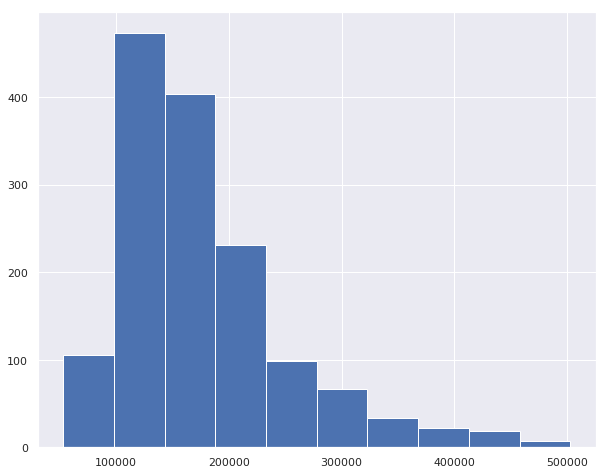

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
plt.figure(figsize=(10,8))
test['SalePrice'].hist();

In [38]:
test.rename(columns={'id': 'Id'}, inplace=True)

In [39]:
submission_path = "submission/house_prices_submission/"

In [40]:
test[['Id', 'SalePrice']].to_csv(submission_path+"lightgbm_house_prices_basic.csv", index=False)